In [17]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Simulation parameters
N = 100  # Number of birds
L = 10  # Size of box
R = 3  # Range for observing other birds
r = 1  # Minimum distance to other birds
v_max = 6  # Maximum velocity
lambda_c = 1
lambda_a = 1
lambda_m = 1
dt = 0.1  # Time step
Nt = 80  # Number of time steps
v0 = 0.5  # velocity
Rsq = R**2
eta = 0.01


# Define drone parameters
N_drones = 1
v_d = v_max
x_drones = np.random.rand(N_drones) * L
y_drones = np.random.rand(N_drones) * L
# Change this line where you initialize v_drones
vx_drones = np.zeros(N_drones)*L
vy_drones = np.zeros(N_drones)*L
R_drone = 1.0  # Detection radius for drones
lambda_d = 1

def initialize_birds(N, L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L
    vx = v0 * np.cos(2 * np.pi * np.random.rand(N, 1))
    vy = v0 * np.sin(2 * np.pi * np.random.rand(N, 1))

    return x, y, vx, vy

def initialize_drones(N, L):
    '''
    Set initial positions and velocities for drones
    '''
    # drone positions
    x = np.random.rand(N, 1) * L
    y = np.random.rand(N, 1) * L

    # drone velocities
    vx = v0 * np.cos(2 * np.pi * np.random.rand(N, 1))
    vy = v0 * np.sin(2 * np.pi * np.random.rand(N, 1))

    return x, y, vx, vy

def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    # update positions for all birds simultaneously
    x += vx * dt
    y += vy * dt

    # apply boundary conditions
    x, y = apply_boundary_conditions(x, y, L)

    return x, y

# Initial positions, velocities, and directions
x, y, vx, vy = initialize_birds(N, L)

# Function to find neighbors within range R
def get_local_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < R and i != j}

# Function to find birds that are too close (within distance r)
def get_too_close_birds(x, y, i):
    return {j: j for j in range(N) if np.linalg.norm([x[j] - x[i], y[j] - y[i]]) < r and i != j}

# Function to limit speed
def limit_speed(vx, vy, v_max):
    speed = np.linalg.norm([vx, vy])
    if speed > v_max:
        vx = (v_max / speed) * vx
        vy = (v_max / speed) * vy     
        print(speed)
    return vx, vy

def update_velocities(x, y, vx_i, vy_i, i, x_drones, y_drones, R_drone):
    local_birds = get_local_birds(x, y, i)
    too_close_birds = get_too_close_birds(x, y, i)

    v_c = lambda_c * (
        (np.sum([x[j] for j in local_birds]) / len(local_birds) - x[i]) if len(local_birds) > 0 else 0,
        (np.sum([y[j] for j in local_birds]) / len(local_birds) - y[i]) if len(local_birds) > 0 else 0
    )

    v_a = lambda_a * (
        (np.sum([x[i] - x[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0),
        (np.sum([y[i] - y[j] for j in too_close_birds]) if len(too_close_birds) > 0 else 0)
    )

    v_m = lambda_m * (
        (np.sum([vx[j] for j in local_birds]) / len(local_birds) - vx_i) if len(local_birds) > 0 else 0,
        (np.sum([vy[j] for j in local_birds]) / len(local_birds) - vy_i) if len(local_birds) > 0 else 0
    )

    drone_directions = lambda_d * np.array([
        np.sum([(x[i] - x_drones[j, 0]) / np.linalg.norm([x[i] - x_drones[j, 0], y[i] - y_drones[j, 0]])**2 for j in range(N_drones)]),
        np.sum([(y[i] - y_drones[j, 0]) / np.linalg.norm([x[i] - x_drones[j, 0], y[i] - y_drones[j, 0]])**2 for j in range(N_drones)])
    ])

    vx_i_new = vx_i + v_c[0] + v_a[0] + v_m[0] 
    vy_i_new = vy_i + v_c[1] + v_a[1] + v_m[1] 

    # Limit speed
    vx_i_new, vy_i_new = limit_speed(vx_i_new, vy_i_new, v_max)

    # Check if the bird is within the observation range of any drone
    for d in range(N_drones):
        distance_to_drone = np.linalg.norm([x[i] - x_drones[d, 0], y[i] - y_drones[d, 0]])
        if distance_to_drone < R_drone:
            # Birds within R_drone experience a negative velocity
            vx_i_new, vy_i_new = -vx_i_new, -vy_i_new
            break
    return vx_i_new, vy_i_new

# Function to update quiver plot data
def update_quiver(quiver, x, y, vx, vy):
    quiver.set_UVC(vx, vy)
    quiver.set_offsets(np.column_stack([x, y]))
    return quiver

# Function to update scatter plot data for drones
def update_drones(scatter, x, y):
    scatter.set_offsets(np.column_stack([x, y]))
    return scatter


def step(x, y, vx, vy, N, dt, L, x_drones, y_drones, R_drone, vx_drones, vy_drones):
    # Update positions and velocities for birds
    for i in range(N):
        x, y = update_positions(x, y, vx, vy, dt, L)
        vx[i], vy[i] = update_velocities(x, y, vx[i], vy[i], i, x_drones, y_drones, R_drone)

        # Calculate new positions and velocities for drones towards the center of mass
    center_of_mass = np.mean(np.column_stack((x, y)), axis=0)
    # print("centre of mass", center_of_mass)
    for i in range(N_drones):
        drone_pos = np.array([x_drones[i], y_drones[i]])
        # print("array of x_d and y_d", drone_pos[0])
        direction = center_of_mass - drone_pos[0]

        # print("direction", direction)
        #direction /= np.linalg.norm(direction)
        # print("normalized", direction)
        vx_drones[i] = lambda_d * direction[0]
        vy_drones[i] = lambda_d * direction[1]

        # Update positions for drones
        x_drones[i] += vx_drones[i] * dt
        y_drones[i] += vy_drones[i] * dt


    x_drones, y_drones = apply_boundary_conditions(x_drones, y_drones, L)

            
    return x, y, vx, vy, x_drones, y_drones, vx_drones, vy_drones



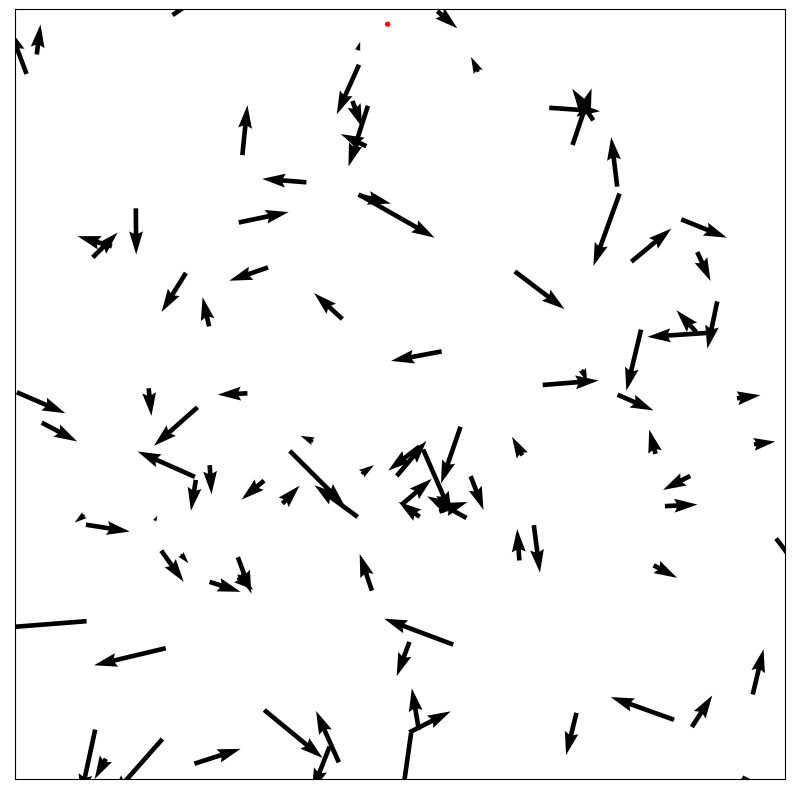

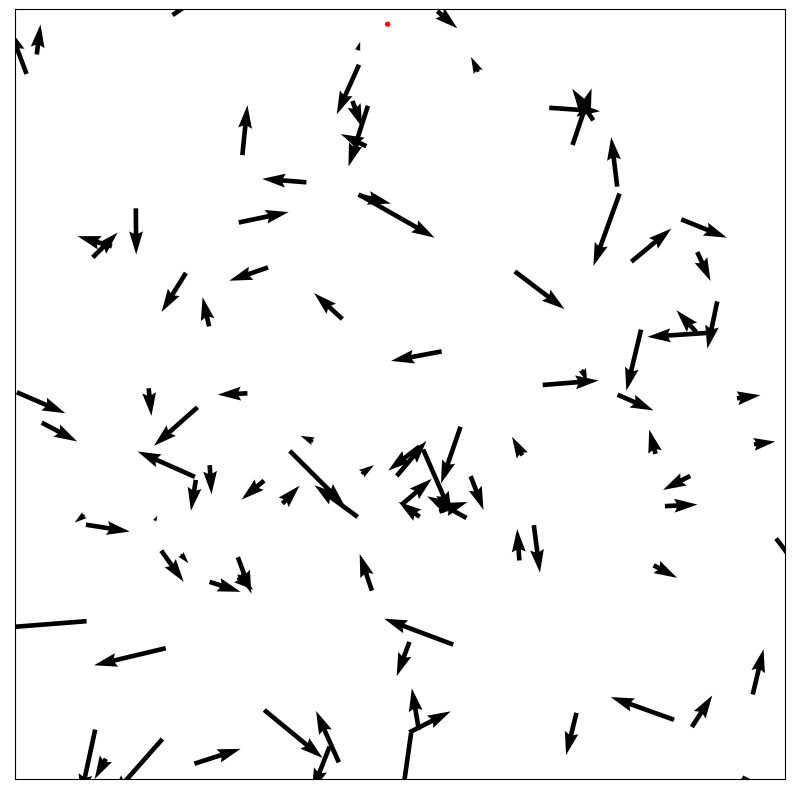

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Assuming initialization of birds and drones
x_birds, y_birds, vx_birds, vy_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(N_drones, L)


# Assuming initialization of quiver and scatter plots
birds_quiver = ax.quiver(x_birds, y_birds, vx_birds, vy_birds, color='black')
drones_quiver = ax.quiver(x_drones, y_drones, vx_drones, vy_drones, color='red')


ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# do each step, updating the quiver and scatter plots
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds, x_drones, y_drones, vx_drones, vy_drones = step(x_birds, y_birds, vx_birds, vy_birds, N, dt, L, x_drones, y_drones, R_drone, vx_drones, vy_drones)
    birds_quiver = update_quiver(birds_quiver, x_birds, y_birds, vx_birds, vy_birds)
    drones_quiver = update_quiver(drones_quiver, x_drones, y_drones, vx_drones, vy_drones)
    clear_output(wait=True)
    display(fig)

TypeError: step() missing 2 required positional arguments: 'vx_drones' and 'vy_drones'

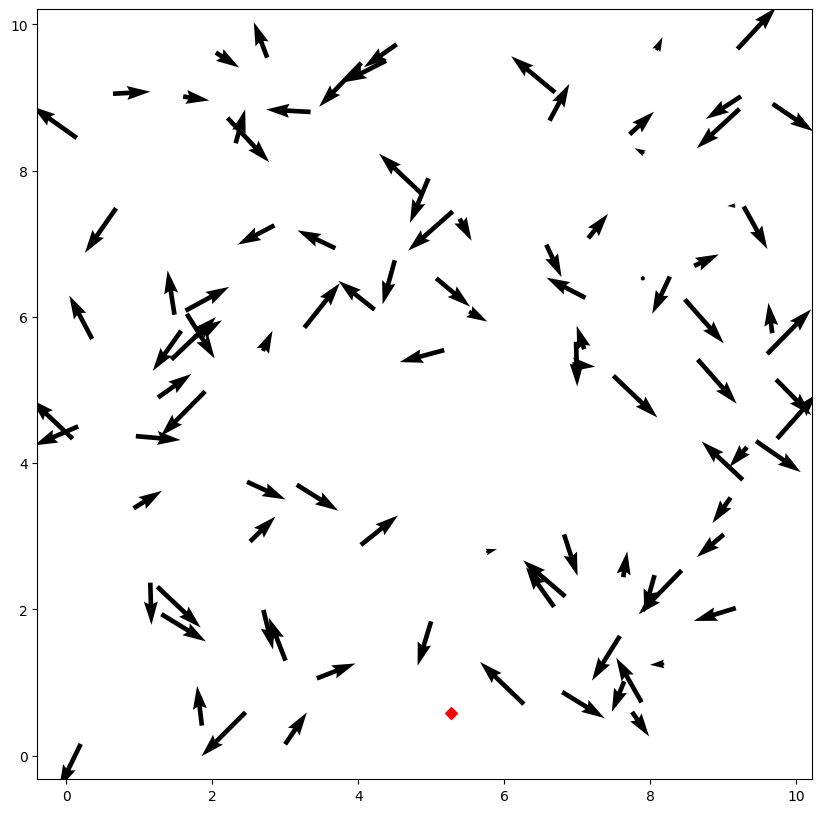

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Assuming initialization of birds and drones
x_birds, y_birds, vx_birds, vy_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(N_drones, L)


# Assuming initialization of quiver and scatter plots
birds_quiver = ax.quiver(x_birds, y_birds, vx_birds, vy_birds, color='black')
drones_scatter = ax.scatter(x_drones, y_drones, color='red', marker='D')


# do each step, updating the quiver and scatter plots
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds, x_drones, y_drones = step(x_birds, y_birds, vx_birds, vy_birds, N, dt, L, x_drones, y_drones, R_drone)

    # Normalize velocity vectors
    mag_birds = np.sqrt(vx_birds**2 + vy_birds**2)
    vx_norm = vx_birds / mag_birds
    vy_norm = vy_birds / mag_birds

    # Directly scale normalized vectors
    scale_factor = 0.1  # Adjust this value to change arrow length
    vx_scaled = vx_norm * scale_factor
    vy_scaled = vy_norm * scale_factor

    # Update quiver plot data for birds
    birds_quiver.set_UVC(vx_scaled, vy_scaled)
    birds_quiver.set_offsets(np.column_stack([x_birds, y_birds]))

    # Update scatter plot data for drones
    update_drones(drones_scatter, x_drones, y_drones)

    ax.set(xlim=(0, L), ylim=(0, L))
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    clear_output(wait=True)
    display(fig)



# do an initial plot and set up the axes
q = plt.quiver(x,y,vx,vy)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x,y,vx,vy = step(x,y,vx,vy,theta,Rsq,eta,N,dt)
    q = update_quiver(q,x,y,vx,vy)
    clear_output(wait=True)
    display(fig)


In [ ]:
# Function to visualize the flock
def visualize(ax, x, y, vx, vy, x_drones, v_drones):
    ax.clear()
    q = ax.quiver(x, y, vx, vy, scale=50, color='blue', width=0.007)
    ax.scatter(x_drones[:, 0], x_drones[:, 1], color='red', marker='D')  # Plot drones in red
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.pause(0.001)
    clear_output(wait=True)
    display(fig)


# set up a figure
fig, ax = plt.subplots(figsize=(10, 10))

# get the initial configuration
x, y, vx, vy, theta = initialize_birds(N, L)

# do an initial plot and set up the axes
visualize(ax, x, y, vx, vy, x_drones, v_drones)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x, y, vx, vy, theta, x_drones, v_drones = step(x, y, vx, vy, theta, Rsq, v0 * eta, N, dt, L, x_drones, v_drones, R)
    visualize(ax, x, y, vx, vy, x_drones, v_drones)